In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # visualization 
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


## To predict whether a passenger is survived or not

### Data Dictionary
survival: Survival	0 = No, 1 = Yes  
pclass: Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd  
sex: Sex	
Age: Age in years	
sibsp: # of siblings / spouses aboard the Titanic	
parch: # of parents / children aboard the Titanic	
ticket: Ticket number	
fare: Passenger fare	
cabin: Cabin number	
embarked: Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton  

### Interesting features from data 
- pclass: 값이 작을수록 더 좋은 클래스임. 순서가 중요
- sibsp, parch: 친족이 함께 승선했는지의 여부(몇 명)를 알 수 있음.
- ticket: 티켓 넘버는 각 승객마다 고유의 값인지 확인이 필요해보이고, 
- embarked: embarked는 승선한 항구의 위치이기 때문에 생존에 직접적인 영향을 미쳤을지 짐작하기 어려움.
- cabin: 객실 번호는 구역이 나누어져있을 것.

In [2]:
# Load Dataset
train_df = pd.read_csv("/kaggle/input/titanic/train.csv")
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# 891 rows, 12 columns
train_df.shape

(891, 12)

In [4]:
# Basic Statistics for numerical values
train_df.describe() 

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
# data types
train_df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

#### 이상치
- Age는 0세에서 80세까지 골고루 분포하고 있음.
- Fare에서 minimum값이 0으로 나오는데, 결측값 또는 이상치인지 확인이 필요함. 
    - 만약 처리가 필요하다면, Pclass를 기준으로 한 평균값으로 대체
  

In [6]:
# To find the rows where Fare == 0 
train_df.loc[train_df['Fare'] == 0]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,NaN,S
466,467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,NaN,S
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,NaN,S
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S


In [7]:
# 각 클래스마다 Fare == 0 인 승객이 있는 것으로 보아, 결측값이 0으로 적힌 것으로 가정하고 처리
# ticket class(pclass)를 기준으로 각 class의 평균값으로 대체

# 1) 먼저, Fare == 0 인 값을 NaN으로 대체하기
train_df['Fare'] = train_df['Fare'].replace(0, np.nan) # replace(기존값, 대체할 값)

# 2) 각 class의 평균값 구하기
mean_class_fare = train_df.groupby('Pclass')['Fare'].mean() # Compute mean of groups, excluding missing values.

# 3) Fare == NaN인 승객들의 class에 따라서 NaN을 class별 평균값으로 대체
train_df['Fare'] = train_df.apply(lambda row:mean_class_fare[row['Pclass']] if pd.isna(row['Fare']) else row['Fare'], axis = 1)
# axis = 0: apply function to each column, axis =1: apply functions to each row
# (https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html)
# (https://stackoverflow.com/questions/48819767/pandas-dataframe-apply-lambda-if-else-erro)

In [8]:
mean_class_fare

Pclass
1    86.148874
2    21.358661
3    13.787875
Name: Fare, dtype: float64

In [9]:
# Check (loc: find a specific row)
train_df.loc[train_df['PassengerId'] == 180] # class 3 passenger

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,13.787875,NaN,S


#### 결측값
- Age, Cabin, Embarked
- Age: (아직 진행 못함)이 중, Age는 변수를 모델에 활용할 경우 처리가 필요해보임.
    - Age의 결측값은 Name에서 미혼/기혼 여부를 가져오고 미혼 평균 나이, 기혼 평균 나이를 활용해서 대체
- Cabin: 결측값은 0으로 대체
    - 데이터를 살펴보니, Cabin 값은 알파벳 - 숫자로 이루어져있음. 추후 다시 결측값 대체 시도
- Embarked: 결측값을 'S'로 대체한 후 벡터화
- (추후 활용) Ticket: 티켓 값이 동일한 경우를 체크해서 다른 변수의 결손값을 대체하는 데에 활용 가능

In [10]:
# Check total number of missing values
train_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [11]:
# Number of unique values (duplicated values?)
train_df.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           250
Cabin          147
Embarked         3
dtype: int64

In [12]:
# Embarked - Missing values
train_df[train_df['Embarked'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [13]:
# Check if there are other passengers who have a same cabin number 
train_df[train_df['Cabin'] == 'B28']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [14]:
# Check if there are other passengers who have a same ticket number
train_df[train_df['Ticket'] == '113572']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [15]:
# Embarked - proportions
train_df.groupby('Embarked').count()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin
Embarked,,,,,,,,,,,
C,168,168,168,168,168,130,168,168,168,168,69
Q,77,77,77,77,77,28,77,77,77,77,4
S,644,644,644,644,644,554,644,644,644,644,129


In [16]:
# Decide to replace null values to 'S' which has the highest proportion 
train_df['Embarked'] = train_df['Embarked'].replace(np.nan, 'S')
train_df[train_df['Cabin'] == 'B28']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,S
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,S


In [17]:
# Cabin - missing values replaced to 0 (for now...:)
train_df['Cabin'].fillna('0', inplace=True)
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,0,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,0,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,0,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,0,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,0,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


### Vectorization: 모델에 넣을 수 있도록 데이터를 벡터화하기
x_1 (passenger id = 1): [0,1,4,....,0] ?
- Name:  일단 제외 
    - Mr. , Mrs. , Miss. , Master. , others 등으로 추후 string에서 특정 단어 추출해서 변수화하기
    - Mr. 517(개) Miss. 182 Mrs. 125 Ms. 1 Master. 40 Rev. 6 Dr. 7 Major. 2 Sir. 3 Mlle. 2 Capt. 1 Countess. 1 Col. 2 Lady. 1 Mme. 1 Don. 1 Jonkheer. 1
    - Mr., Miss., Mrs., Master, others로 구분 가능
- Pclass: 1,2,3 순서가 중요함. 직관적으로 생각해보면 1등석이 생존 확률이 높을 것인데, 역으로 바꿔서 넣어야 할 필요가 있을까? (1등석:3, 2등석:2, 3등석:1)
- Sex: 0과 1
- Cabin: 알파벳을 기준
- Embarked: S,C,Q를 각각 더미변수화
- Ticket: 일단 제외 
    - 추후, 동일한 ticket값을 가지고 있는 사용자는 동승자라고 확인해주는 새로운 변수 생성 가능 (이때 SibSp, Parch등도 활용할 수 있음 - 가족 관계)
-------------------------------------------------------------------------------------
- Index = PassengerId
- Output = Survived

In [18]:
train_df_vec = train_df.set_index("PassengerId")
output_df = train_df["Survived"]
train_df_vec = train_df_vec.drop(columns = ["Survived", "Name","Ticket"])

In [19]:
# Sex: 'Male' = 0, 'Female' = 1
train_df_vec['Sex'] = train_df_vec['Sex'].map({'male':0, 'female':1})
train_df_vec.head()
# 궁금한 점: 열 하나에서 0,1로 나누는 것과, Female 열 , Male열을 나누는 것에 차이? class가 2개이기 때문에 상관 없음. 그 이상은 생각해봐야함. 

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
PassengerId,,,,,,,,
1,3,0,22.0,1,0,7.2500,0,S
2,1,1,38.0,1,0,71.2833,C85,C
3,3,1,26.0,0,0,7.9250,0,S
4,1,1,35.0,1,0,53.1000,C123,S
5,3,0,35.0,0,0,8.0500,0,S


In [20]:
# Embarked: 'S', 'Q', 'C' - make dummies for vectorization
train_df_vec = pd.get_dummies(train_df_vec, columns=['Embarked'], prefix='Embarked') 
# prefix: String to append DataFrame column names.
train_df_vec.head()
#! get_dummies로는 True and False가 아닌 1과 0값으로 나오게 할 수는 없나...?

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,
1,3,0,22.0,1,0,7.2500,0,False,False,True
2,1,1,38.0,1,0,71.2833,C85,True,False,False
3,3,1,26.0,0,0,7.9250,0,False,False,True
4,1,1,35.0,1,0,53.1000,C123,False,False,True
5,3,0,35.0,0,0,8.0500,0,False,False,True


In [21]:
# Cabin - using first letter of the cabin number ('A', 'B'...)
train_df_vec['Cabin'] = train_df_vec['Cabin'].str[0]
train_df_vec.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,
1,3,0,22.0,1,0,7.2500,0,False,False,True
2,1,1,38.0,1,0,71.2833,C,True,False,False
3,3,1,26.0,0,0,7.9250,0,False,False,True
4,1,1,35.0,1,0,53.1000,C,False,False,True
5,3,0,35.0,0,0,8.0500,0,False,False,True


In [22]:
train_df_vec.groupby('Cabin').count()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
Cabin,,,,,,,,,
0,687,687,529,687,687,687,687,687,687
A,15,15,12,15,15,15,15,15,15
B,47,47,45,47,47,47,47,47,47
C,59,59,51,59,59,59,59,59,59
D,33,33,31,33,33,33,33,33,33
E,32,32,30,32,32,32,32,32,32
F,13,13,11,13,13,13,13,13,13
G,4,4,4,4,4,4,4,4,4
T,1,1,1,1,1,1,1,1,1


In [23]:
train_df_vec.groupby(['Cabin','Pclass']).count()

Sex  Age  SibSp  Parch  Fare  Embarked_C  Embarked_Q  Embarked_S
Cabin Pclass                                                                  
0     1        40   26     40     40    40          40          40          40
      2       168  158    168    168   168         168         168         168
      3       479  345    479    479   479         479         479         479
A     1        15   12     15     15    15          15          15          15
B     1        47   45     47     47    47          47          47          47
C     1        59   51     59     59    59          59          59          59
D     1        29   27     29     29    29          29          29          29
      2         4    4      4      4     4           4           4           4
E     1        25   24     25     25    25          25          25          25
      2         4    3      4      4     4           4           4           4
      3         3    3      3      3     3           3           3           3
F     2         8    8      8      8     8           8           8           8
      3         5    3      5      5     5           5           5           5
G     3         4    4      4      4     4           4           4           4
T     1         1    1      1      1     1           1           1           1

In [24]:
train_df_vec

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,
1,3,0,22.0,1,0,7.2500,0,False,False,True
2,1,1,38.0,1,0,71.2833,C,True,False,False
3,3,1,26.0,0,0,7.9250,0,False,False,True
4,1,1,35.0,1,0,53.1000,C,False,False,True
5,3,0,35.0,0,0,8.0500,0,False,False,True
...,...,...,...,...,...,...,...,...,...,...
887,2,0,27.0,0,0,13.0000,0,False,False,True
888,1,1,19.0,0,0,30.0000,B,False,False,True
889,3,1,NaN,1,2,23.4500,0,False,False,True


## Visualization 
- How variables affect the survival rate

In [25]:
# Survival rate based on Sex
train_df[['Survived', 'Sex']].groupby('Sex').mean()

,Survived
Sex,
female,0.742038
male,0.188908


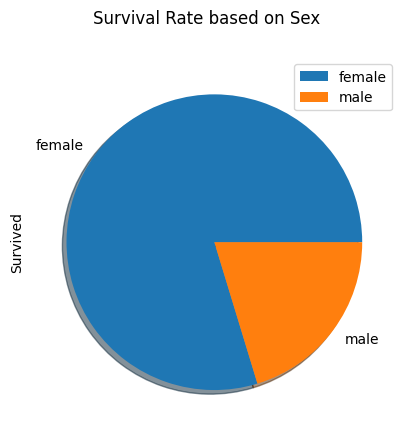

In [26]:
# Pie chart for survival rate based on Sex
data = train_df[['Survived', 'Sex']].groupby('Sex').mean()
data.plot(kind = 'pie', shadow = True, title = "Survival Rate based on Sex", subplots = True)
plt.show()

In [27]:
train_df[['Survived', 'Sex']].groupby(['Sex']).count()

,Survived
Sex,
female,314
male,577


Text(0.5, 1.0, 'Counts of Male, Female')

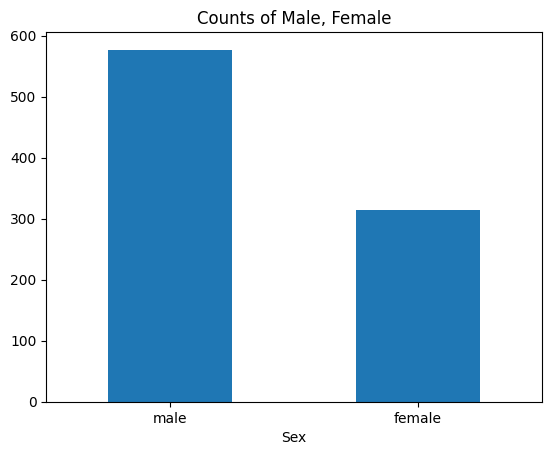

In [28]:
# Bar plot for Counts of each male and female
train_df['Sex'].value_counts().plot.bar()
plt.xticks(rotation = 0) # horizontal label :) 
plt.title("Counts of Male, Female")

- 각 column별 bar chart를 그려주는 함수

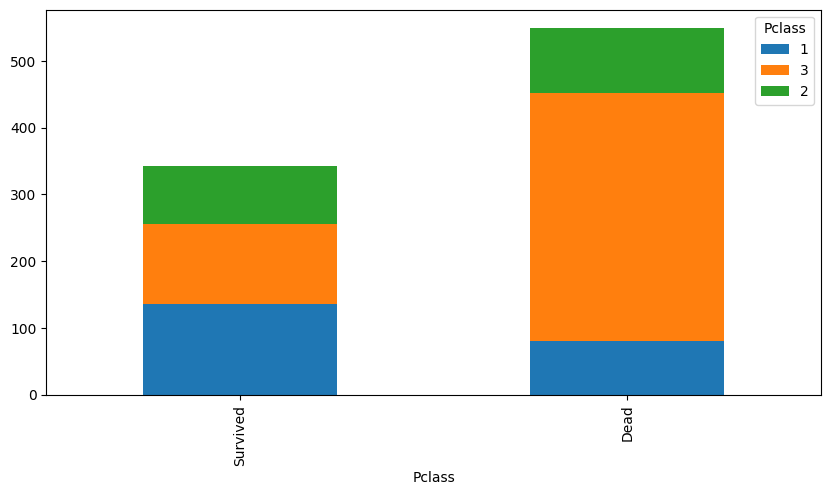

In [29]:
def bar_chart(feature):
    # 각 column(=feature)에서 생존자 수 count
    survived = train_df[train_df['Survived']==1][feature].value_counts()
    # 각 column(=feature)에서 사망자 수 count
    dead = train_df[train_df['Survived']==0][feature].value_counts()
    # 생존자수, 사망자수를 하나의 dataframe으로 묶는다.
    df = pd.DataFrame([survived, dead])
    # 묶은 dataframe의 인덱스명(행 이름)을 지정한다.
    df.index = ['Survived', 'Dead']
    # plot을 그린다.
    df.plot(kind='bar', stacked=True, figsize=(10,5), xlabel=feature)
# return df
bar_chart('Pclass')